required packages

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.utils import resample
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

reading csv file

In [13]:
train_df=pd.read_csv('mitbih_test.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [14]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    18118
4     1608
2     1448
1      556
3      162
Name: count, dtype: int64


In [15]:
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42,replace=True)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [16]:
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64


In [17]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)

In [18]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [19]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
print(X_train.shape)
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(X_test.shape[1],len(X_train))

(100000, 186)
186 100000


In [20]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='sample_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('sample_model.h5')
    return(model,history)

In [21]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [22]:
model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/40
3125/3125 [==============================] - 96s 30ms/step - loss: 0.8908 - accuracy: 0.6545 - val_loss: 0.5015 - val_accuracy: 0.8612
Epoch 2/40
   1/3125 [..............................] - ETA: 1:51 - loss: 0.8256 - accuracy: 0.6875

C:\Users\JB\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3125/3125 [==============================] - 93s 30ms/step - loss: 0.7849 - accuracy: 0.6980 - val_loss: 1.2739 - val_accuracy: 0.2368
Epoch 3/40
3125/3125 [==============================] - 95s 30ms/step - loss: 0.7493 - accuracy: 0.7125 - val_loss: 1.0585 - val_accuracy: 0.4852
Epoch 4/40
3125/3125 [==============================] - 93s 30ms/step - loss: 0.7226 - accuracy: 0.7222 - val_loss: 1.5484 - val_accuracy: 0.3507
Epoch 5/40
3125/3125 [==============================] - 94s 30ms/step - loss: 0.6962 - accuracy: 0.7331 - val_loss: 1.9776 - val_accuracy: 0.1282
Epoch 6/40
3125/3125 [==============================] - 91s 29ms/step - loss: 0.6721 - accuracy: 0.7423 - val_loss: 2.0503 - val_accuracy: 0.1639
Epoch 7/40
3125/3125 [==============================] - 93s 30ms/step - loss: 0.6456 - accuracy: 0.7518 - val_loss: 2.1588 - val_accuracy: 0.1221
Epoch 8/40
3125/3125 [==============================] - 92s 29ms/step - loss: 0.6172 - accuracy: 0.7645 - val_loss: 3.0396 - val_accura

Accuracy: 86.12%


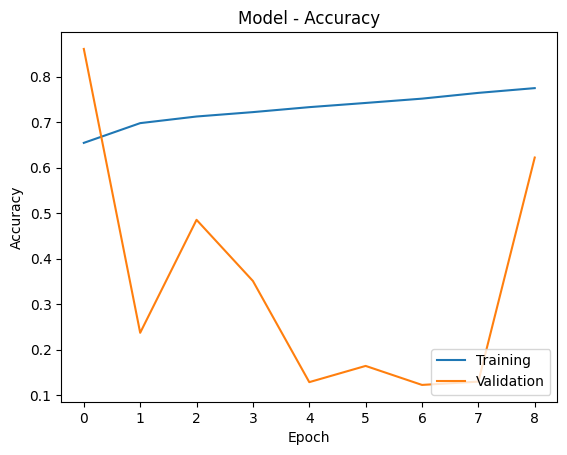

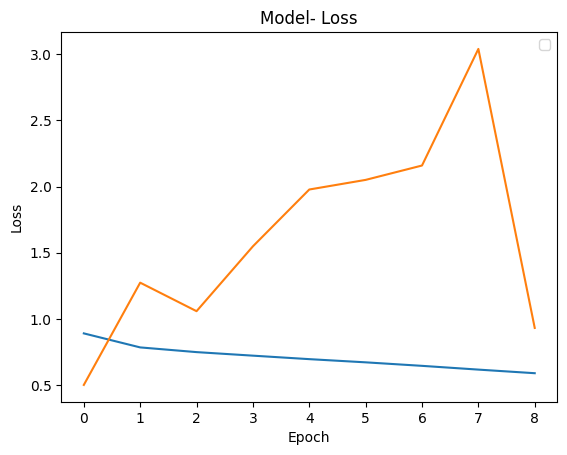

685/685 [==============================] - 5s 7ms/step


In [23]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)